In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title=None):
    npimg = img.numpy()
    plt.figure()
    if title:
        plt.title(title)
    npimg = np.transpose(npimg, (1,2,0))
    cmap = None
    if npimg.shape[-1] not in [3,4]:
        npimg = npimg[:,:,0]
        cmap = 'gray'
    plt.imshow(npimg, interpolation='nearest', cmap=cmap)

In [16]:
epochs = 1

# UTKFace Data

In [3]:
batch_size = 128

In [4]:
from data import UTKFace
dataset = UTKFace(transform=transforms.Compose([
                    transforms.Grayscale(),
                    transforms.Resize((256, 256)), 
                    transforms.ToTensor()])
                 )

In [5]:
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
data_size, train_size, test_size

(23708, 18966, 4742)

In [6]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

### Toggle cell below for sample debugging

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)

In [8]:
a_face = dataset[0][0]
show(a_face)

torch.Size([1, 256, 256])

# VAE Model

In [10]:
from models import VAE

In [11]:
device = torch.device("cuda")

In [12]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in tqdm(enumerate(test_loader)):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += model.loss(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 256, 256)[:n]])
                show(make_grid(comparison.cpu(), nrow=n), 'Reconstruction {}'.format(epoch))

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# Load

In [14]:
weight_path = 'weights/{}_{}.pt'.format(model.__class__.__name__, dataset.__class__.__name__)
weight_path

'weights/VAE_UTKFace.pt'

In [15]:
model.load_state_dict(torch.load(weight_path))    

# Train

100%|██████████| 149/149 [02:04<00:00,  1.56it/s]

====> Epoch: 1 Average loss: 41014.6807



38it [00:12,  3.07it/s]


====> Test set loss: 39857.0962
CPU times: user 1min 28s, sys: 49.1 s, total: 2min 17s
Wall time: 2min 17s


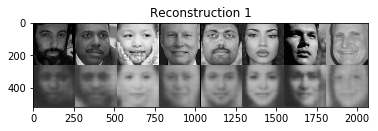

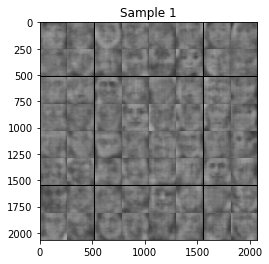

In [17]:
%%time
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 50).to(device)
        sample = model.decode(sample).cpu()
        show(make_grid(sample.view(64, 1, 256, 256)), 'Sample {}'.format(epoch))

# Save

In [18]:
torch.save(model.state_dict(), weight_path)